# Финальный проект, вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

* В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
* Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
* Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.
 

In [1]:
# Загрузка нужных библиотек 

import pandas as pd
import numpy as np
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.stats import norm
from tqdm.auto import tqdm

## Задание 1

Retention – один из самых важных показателей в компании.
Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 
* problem1-reg_data.csv – данные о времени регистрации
* problem1-auth_data.csv – данные о времени захода пользователей в игру

In [4]:
data_1 = pd.read_csv('problem1-reg_data.csv', sep=';')
data_2 = pd.read_csv('problem1-auth_data.csv', sep=';')

In [5]:
# Рассмотрим данные о регистрации пользователей подробно, проверим тип и пустые значения
data_1.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [6]:
data_1.dtypes

reg_ts    int64
uid       int64
dtype: object

In [7]:
data_1.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [8]:
# Аналогично рассмотрим данные о времени захода пользователей в игру
data_2.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
data_2.dtypes

auth_ts    int64
uid        int64
dtype: object

In [10]:
data_2.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [11]:
# Функция для подсчета Retention, на вход подаются два датафрейма

def calc_retention(data_reg, data_auth):
    # перевод timestamp в datetime формат
    data_reg.reg_ts = pd.to_datetime(data_reg.reg_ts, unit='s')
    data_reg.reg_ts = pd.to_datetime(data_reg.reg_ts)
    
    data_auth.auth_ts = pd.to_datetime(data_auth.auth_ts, unit='s')
    data_auth.auth_ts = pd.to_datetime(data_auth.auth_ts)
    
    # объединение в один датафрейм по user id
    data = data_reg.merge(data_auth, how='inner', on='uid')
    data['n_days'] = (data.auth_ts - data.reg_ts).dt.days
    
    # подсчет Retention за весь период
    retention = (data.groupby('n_days')['uid'].nunique() / data['uid'].nunique()) * 100
    
    return retention

In [12]:
retention = calc_retention(data_1, data_2)
retention.head()

n_days
0    100.0000
1      4.0202
2      4.2991
3      4.9152
4      5.6070
Name: uid, dtype: float64

Уже можно заметить, что только 4% пользователей остается на следующий день после регистрации

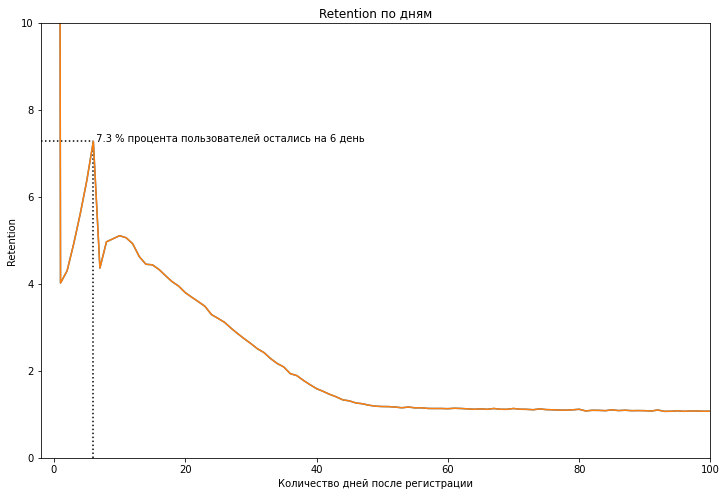

In [16]:
# Визуализируем Retention за 100 дней

plt.figure(figsize=(12, 8))
plt.plot(retention)
plt.ylim(0.0, 10)
plt.xlim(-2, 100)

plt.plot(retention)
plt.title("Retention по дням")
plt.xlabel("Количество дней после регистрации")
plt.ylabel("Retention")

plt.hlines(y=retention.loc[6], xmin=-2, xmax=6, linestyles='dotted')
plt.vlines(x=6, ymin=0, ymax=retention.loc[6], linestyles='dotted')
plt.text(s=(" {:.1f} % процента пользователей остались на 6 день".format(retention.loc[6])), x=6, y=retention.loc[6]);

Из полученного графика можно сделать вывод, что самый большой отток пользователей происходит в первые дни после установки, затем он сокращается (на 4-6 день даже происходит небольшое увеличение Retention), и в приложении остаются наиболее лояльные пользователи.

## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [17]:
# Загрузка данных с Яндекс Диска

import requests
import json
from urllib.parse import urlencode

# Получаем загрузочную ссылку
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/12gk_ATEeBZm4A'
final_url = base_url + urlencode(dict(public_key=public_key))

# Подготовка ссылки на скачивание
response = requests.get(final_url)
h = json.loads(response.text)['href']

# Загрузка данных в dataframe
df = pd.read_csv(h, sep=';')

In [18]:
# Рассмотрим данные подробно, проверим тип и пустые значения
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [19]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [20]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [21]:
# Добавим колонку, которая указывает является ли пользователь платящим (1) или нет (0)
df['is_pay'] = np.where(df.revenue > 0, 1, 0)

In [22]:
df

,user_id,revenue,testgroup,is_pay
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
...,...,...,...,...
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0


Для принятия решения результаты какой группы лучше, нужно рассмотреть метрики, которые позволяют описать насколько успешна монетизация. А именно:
* **Revenue** - суммарный доход по группам, 
* **Paying conversion** - доля платящих пользователей, от всех пользователей группы, 
* **ARPU** -  средняя выручка на одного пользователя, 
* **ARPPU** - средняя выручка с одного платящего пользователя.

In [23]:
# Проверим нормально ли распределен доход пользователей в группах
stats.shapiro(df.query('testgroup == "a"').revenue)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.008876502513885498, 0.0)

In [24]:
stats.shapiro(df.query('testgroup == "b"').revenue)

(0.06588172912597656, 0.0)

Распределения по доходу для двух групп не являются нормальными. Для определения является ли различие среднего по доходу статистически значимым, используем **bootstrap метод**

In [25]:
# Объявим функцию, которая позволит проверять гипотезу о сравнении средних значений с помощью бутстрапа
def get_bootstrap_mean(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

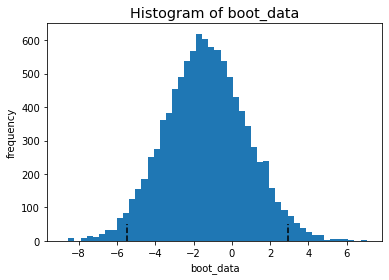

In [26]:
# Проверка гипотезы о равенстве средних с помощью бутстрапа
booted_data_1 = get_bootstrap_mean(df[df.testgroup == 'a'].revenue, df[df.testgroup == 'b'].revenue, boot_it=10000)

In [27]:
# Интерпретация результата
p_val_1 = booted_data_1["p_value"]
print('p=%.3f' % (p_val_1))
alpha = 0.05

if p_val_1 > alpha:
    print('Не можем отклонить H0')
else:
    print('Отклоняем H0')

p=0.530
Не можем отклонить H0


Различия между средними групп не являются статически значимыми

In [28]:
# Расчет Revenue по группам
gr_0 = df \
    .groupby(['testgroup'], as_index=False) \
    .agg({'user_id': 'nunique', 'revenue': 'sum'})

gr_0

,testgroup,user_id,revenue
0,a,202103,5136189
1,b,202667,5421603


In [29]:
# Расчет конверсии в покупку по группам - Paying conversion

# датафрейм с платящими пользователями
gr_01 = df.query('revenue != 0') \
    .groupby(['testgroup'], as_index=False) \
    .agg({'user_id': 'nunique'})

# объединение в один датафрейм по testgroup 
gr_1 = gr_01.merge(gr_0, how='inner', on='testgroup')

# добавление колонки и расчет Paying conversion
gr_1['paying_cov'] = (gr_1.user_id_x / gr_1.user_id_y) * 100
gr_1 = gr_1.rename(columns={'user_id_x': 'paying_users', 'user_id_y': 'all_users'})

In [30]:
gr_1

,testgroup,paying_users,all_users,revenue,paying_cov
0,a,1928,202103,5136189,0.953969
1,b,1805,202667,5421603,0.890624


Проверим является ли разница Paying conversion в группах статистически значимой с помощью критерия **хи-квадрат**

In [31]:
# Сводная таблица платящих/ не платящих пользователей группы
table = pd.crosstab(df.testgroup, df.is_pay)

table

is_pay,0,1
testgroup,,
a,200175,1928
b,200862,1805


In [32]:
chi2, prob, dof, expected = scipy.stats.chi2_contingency(table)

In [33]:
if prob > alpha:
    print('Не можем отклонить H0')
else:
    print('Отклоняем H0')

Отклоняем H0


Следовательно, различие в  Paying conversion является статистически значимым

In [34]:
# Расчет ARPU 
gr_1['ARPU'] = gr_1.revenue / gr_1.all_users

# Расчет ARPPU 
gr_1['ARPPU'] = gr_1.revenue / gr_1.paying_users

In [35]:
gr_1

,testgroup,paying_users,all_users,revenue,paying_cov,ARPU,ARPPU
0,a,1928,202103,5136189,0.953969,25.413720,2663.998444
1,b,1805,202667,5421603,0.890624,26.751287,3003.658172


Исходя из условия задания, определим группу A как тестовую, группу B как контрольную. 

Уже можно заметить, что не смотря на что в тестовой группе метрики Revenue ,ARPU и ARPPU (последняя на 11%) выше, конверсия в покупку значимо выше в контрольной группе . 

Подробней рассмотрим распределение доходов платящих пользователей двух групп.

In [36]:
# Платящие пользователи группы A
df_pay_a = df.query('revenue != 0 & testgroup == "a"')

In [37]:
# Платящие пользователи группы B
df_pay_b = df.query('revenue != 0 & testgroup == "b"')

In [38]:
# Проверим нормально ли распределен доход пользователей в группах
stats.shapiro(df_pay_a.revenue)

(0.2667924761772156, 0.0)

In [39]:
stats.shapiro(df_pay_b.revenue)

(0.9583123922348022, 2.491345674771425e-22)

Распределения по доходу для двух групп не являются нормальными. Для определения является ли различие среднего по доходу статистически значимым, используем bootstrap метод, определенный выше

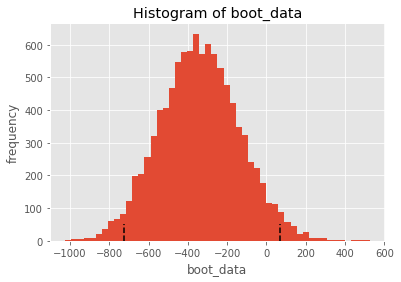

In [40]:
booted_data_2 = get_bootstrap_mean(df_pay_a.revenue, df_pay_b.revenue, boot_it=10000)

In [41]:
# Интерпретация результата
p_val_2 = booted_data_1["p_value"]
print('p=%.3f' % (p_val_2))

if p_val_2 > alpha:
    print('Не можем отклонить H0')
else:
    print('Отклоняем H0')

p=0.530
Не можем отклонить H0


Различия между средними групп не являются статически значимыми. 

Однако стоит сравнить распределения дохода по группам с помощью Boxplot графика

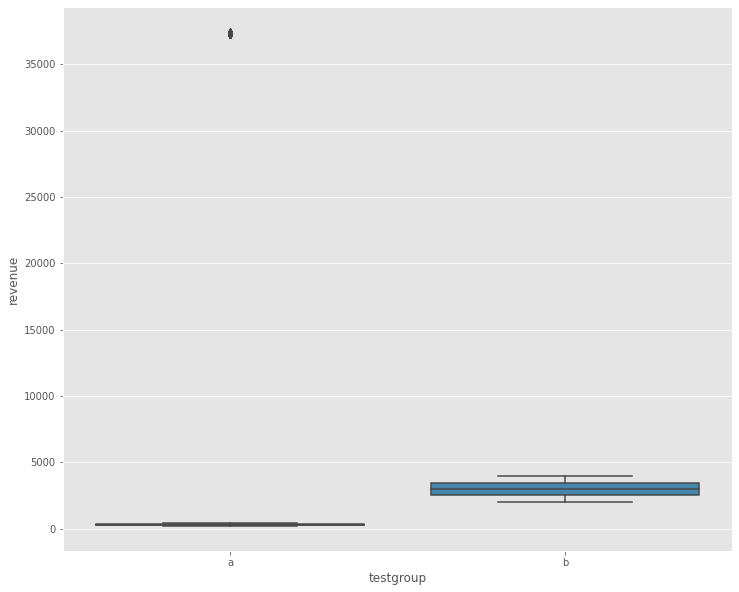

In [42]:
# Boxplot график распределений дохода в группах
plt.figure(figsize=(12, 10))
sns.boxplot(x='testgroup', y='revenue', data=df.query('revenue != 0'));

Из полученных графиков можно сделать выводы:
* Основная доля пользователей контрольной группы совершает покупки на небольшую сумму, только малая часть пользователей совершила покупки на сумму превышающую 35000
* Основная доля пользователей тестовой группы совершает покупки на суммы, которые в несколько раз выше сумм покупок основных пользователей контрольной группы.

Чтобы окончательно в этом убедится посмотрим на описательную статистику по группам, и число пользователей в контрольной группе, которые совершили покупку на сумму выше 35000 

In [43]:
# Описательная статистика группы А
df_pay_a.revenue.describe() 

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [44]:
# Число пользователей в группе A, которые совершили покупку на сумму выше 35000
df_pay_a.query('revenue > 35000').user_id.nunique()

123

In [45]:
# Описательная статистика группы B
df_pay_b.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Таким образом, исходя из того, что значения метрик Revenue, ARPU и ARPPU выше в тестовой группе, а также того что основная доля пользователей тестовой группы совершает покупки на суммы, которые в несколько раз выше сумм покупок основных пользователей контрольной группы, **набор предложений тестовой группы является более привлекательным**.

Однако данный вывод нельзя считать точным, так как в тестовой группе значительно меньше конверсия в покупку. Для более точного ответа лучше рассмотреть дополнительные параметры (такие как время покупки), которые могли повлиять на доход в двух группах. Зная дополнительные параметры стоит рассмотреть метрики:
* FTPUE - сессия в рамках которой пользователь делает свой первый платеж
* LTV - прибыль, за весь период работы с пользователем

И провести RFM сегментацию пользователей приложения по доходу

## Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Метрики, которые можно использовать для определения результатов последнего прошедшего события:

#### Целевые: Показатели данных метрик будут говорить о том, насколько предложение заинтересовало пользователей
* Skip Rate - доля игроков, которые не стали проходить специальные уровни
* DAU (Daily Active Users)/WAU (Weekly Active Users)/MAU (Monthly Active Users) - количество уникальных пользователей за сутки в период события
* Retention  - удержание пользователей за данный месяц (с начала события)

#### Опережающие: С помощью данных метрик можно понять насколько сбалансированы специальные уровни и замотивированы ли пользователи проходить их до конца
* Конверсия - доля игроков, которые прошли специальные уровни от начала до конца
* Конверсия по уровням - доля игроков, дошедших до уровня N


#### Guardrail: С помощью данных метрик можно понять насколько сложно пользователям дается прохождение специальных уровней
* Среднее время прохождения специальных уровней

### Метрики, которые можно добавить к предыдущим после изменения события:

* Churn Rate – отток пользователей после нововведений (в Целевые метрики)
* Количество попыток прохождения уровня N (в Guardrail метрики) 

Высокие показатели данных метрик будут означать, что пользователям не понравились новвоведения из-за того, что сложность прохождения специальных уровней возросла.

Также для понимания того, как аудитория приложения приняла изменения, можно проанализировать изменение **Средней оценки пользователей** до и после нововведений или провести опрос через форму обратной связи для подсчета **NPS (Net Promoter Score)** 